             Name  i  x0_ 1  x0_ 2  x0_ 3       x0_ 4       x0_ 5     x0_ 6  \
0  adolescent#001  1      0      0      0  250.621836  176.506560  4.697518   
1  adolescent#002  2      0      0      0  280.236267   30.954131  6.019305   
2  adolescent#003  3      0      0      0  326.553380  383.368339  3.487881   
3  adolescent#004  4      0      0      0  248.117090  214.758608  4.316765   
4  adolescent#005  5      0      0      0  279.047113  144.715759  5.162898   

   x0_ 7    x0_ 8  ...      kd     ksc     ka1     ka2  dosekempt      u2ss  \
0      0   97.554  ...  0.0185  0.0560  0.0025  0.0115      90000  1.216976   
1      0  119.180  ...  0.0163  0.1314  0.0068  0.0269      90000  1.798300   
2      0  101.280  ...  0.0149  0.1059  0.0030  0.0148      90000  1.446266   
3      0  108.880  ...  0.0155  0.0751  0.0026  0.0121      90000  1.762633   
4      0  113.090  ...  0.0151  0.0866  0.0032  0.0177      90000  1.534645   

      isc1ss      isc2ss        kp1  patient_histo

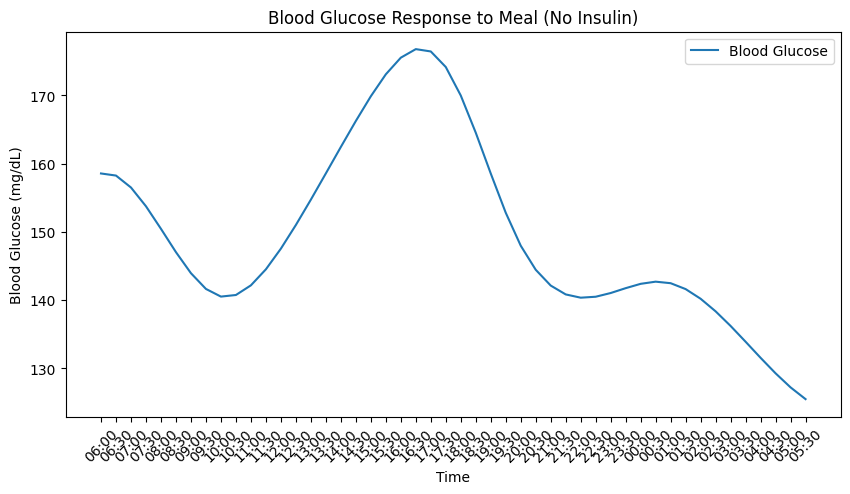

In [16]:
import gym
import simglucose.simulation.scenario as scenario
from simglucose.controller.base import Action
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.user_interface import simulate
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pkg_resources  # 데이터 파일 경로 찾기용

from simglucose.simulation.scenario import CustomScenario

now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

# 1️⃣ 환자 데이터 직접 불러오기
patient_name = 'adult#001'
patient_params_file = pkg_resources.resource_filename(
    'simglucose', 'params/vpatient_params.csv'
)
patient_params = pd.read_csv(patient_params_file)

# 🔹 데이터 확인
print(patient_params.head())  # 데이터 미리보기
print(f"Available patients: {patient_params['Name'].unique()}")

if patient_name not in patient_params['Name'].values:
    raise ValueError(f"Patient {patient_name} not found in dataset!")

# 🔹 해결: 환자 데이터 가져오면서 'Name' 컬럼 포함
patient_data = patient_params[patient_params['Name'] == patient_name].iloc[0]  # DataFrame → Series 변환

# 2️⃣ 환자 객체 생성 (params 전달 방식 수정)
patient = T1DPatient(params=patient_data)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]

# 3️⃣ CGM 센서 및 인슐린 펌프 설정 (✔ 올바른 방식으로 수정)
sensor = CGMSensor.withName('Dexcom')  # 🚀 수정된 부분
pump = InsulinPump.withName('Insulet')  # 🚀 수정된 부분
scenario = CustomScenario(start_time=start_time, scenario=scen)


# 4️⃣ 시뮬레이션 환경 생성 (식단 정보만 반영)
env = T1DSimEnv(patient, sensor, pump, scenario)

# 5️⃣ 식단 입력: 특정 시간에 탄수화물 섭취량 직접 설정
meal_times = [8, 12, 18]  # 아침, 점심, 저녁
meal_carbs = [60, 75, 80]  # 각 식사별 탄수화물량 (단위: g)

# 6️⃣ 시뮬레이션 실행
obs = env.reset()
results = []
sim_time = datetime.now().replace(hour=6, minute=0, second=0)  # 6AM부터 시작

for t in range(48):  # 48시간 동안 혈당 변화 예측
    if sim_time.hour in meal_times:
        carb_intake = meal_carbs[meal_times.index(sim_time.hour)]
    else:
        carb_intake = 0  # 식사 시간이 아닐 경우 탄수화물 섭취 없음

    action = Action(basal=0, bolus=0)  # 인슐린 주입 없이 시뮬레이션
    obs, reward, done, info = env.step(action)
    
    results.append({
        'time': sim_time.strftime('%H:%M'),
        'blood_glucose': obs.CGM,
        'carb_intake': carb_intake
    })
    
    sim_time += timedelta(minutes=30)  # 30분 간격으로 시뮬레이션

# 7️⃣ 결과 출력
df = pd.DataFrame(results)
print(df)

# 8️⃣ 그래프 출력
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['blood_glucose'], label="Blood Glucose")
plt.xlabel('Time')
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Blood Glucose Response to Meal (No Insulin)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
import gym
import simglucose.simulation.scenario as scenario
from simglucose.controller.base import Action
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.user_interface import simulate
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
from simglucose.simulation.scenario import CustomScenario

# iAUC 계산 함수
def calculate_iauc(glucose_levels, baseline=110):
    increments = np.maximum(np.array(glucose_levels) - baseline, 0)
    return np.trapz(increments)

# 1️⃣ 9일치 식단 (group_a_meal_plan)
group_a_meal_plan = pd.DataFrame({
    'Day': [f'Day {i}' for i in range(1, 10)],
    'Breakfast (g)': [66, 64, 36, 51, 41, 47, 41, 23, 60],
    'Lunch (g)':     [40, 45, 25, 35, 45, 27, 32, 45, 71],
    'Dinner (g)':    [55, 66, 30, 50, 30, 32, 30, 46, 51]
})

# 2️⃣ 환자 설정
patient_name = 'adult#001'
patient_params_file = pkg_resources.resource_filename('simglucose', 'params/vpatient_params.csv')
patient_params = pd.read_csv(patient_params_file)

if patient_name not in patient_params['Name'].values:
    raise ValueError(f"Patient {patient_name} not found in dataset!")

patient_data = patient_params[patient_params['Name'] == patient_name].iloc[0]
patient = T1DPatient(params=patient_data)

sensor = CGMSensor.withName('Dexcom')
pump = InsulinPump.withName('Insulet')

# 3️⃣ 시뮬레이션 시작
start_time = datetime.combine(datetime.now().date(), datetime.min.time())
meal_times = [8, 12, 18]  # 식사 시간

total_results = []
glucose_curve = []

for day in range(9):
    # 하루 식단 구성
    meal_carbs = [
        group_a_meal_plan.iloc[day]['Breakfast (g)'],
        group_a_meal_plan.iloc[day]['Lunch (g)'],
        group_a_meal_plan.iloc[day]['Dinner (g)']
    ]
    scen = [(meal_times[i], meal_carbs[i]) for i in range(3)]
    scenario = CustomScenario(start_time=start_time, scenario=scen)
    env = T1DSimEnv(patient, sensor, pump, scenario)

    # 하루 시뮬레이션
    obs = env.reset()
    sim_time = datetime.now().replace(hour=6, minute=0, second=0)
    
    for t in range(48):  # 하루 48 step = 24시간
        if sim_time.hour in meal_times:
            carb_intake = meal_carbs[meal_times.index(sim_time.hour)]
        else:
            carb_intake = 0

        action = Action(basal=0, bolus=0)
        obs, reward, done, info = env.step(action)

        glucose = obs.CGM
        glucose_curve.append(glucose)

        total_results.append({
            'day': day + 1,
            'time': sim_time.strftime('%Y-%m-%d %H:%M'),
            'blood_glucose': glucose,
            'carb_intake': carb_intake
        })

        sim_time += timedelta(minutes=30)

# 4️⃣ 결과 DataFrame
df = pd.DataFrame(total_results)

# 5️⃣ iAUC 계산
iauc = calculate_iauc(glucose_curve)
print(f"\n✅ 9일간 시뮬레이션 iAUC: {iauc:.2f}\n")
print(f"\n✅ 식단 당 iAUC: {iauc/27:.2f}\n")

# 6️⃣ 그래프 출력
plt.figure(figsize=(12, 5))
plt.plot(df['blood_glucose'].values, label="Blood Glucose")
plt.xlabel('Time Step (30min x n)')
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Blood Glucose over 9 Days (No Insulin)')
plt.legend()
plt.grid(True)
plt.show()


: 

In [6]:
import gym
import simglucose.simulation.scenario as scenario
from simglucose.controller.base import Action
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.user_interface import simulate
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
from simglucose.simulation.scenario import CustomScenario

# iAUC 계산 함수
def calculate_iauc(glucose_levels, baseline=110):
    increments = np.maximum(np.array(glucose_levels) - baseline, 0)
    return np.trapz(increments)

# A군 식단 (9일치) ours
group_a_meal_plan = pd.DataFrame({
    'Day': [f'Day {i}' for i in range(1, 10)],
    'Breakfast (g)': [42, 42, 48, 59, 58, 41, 36, 36, 59],
    'Lunch (g)':     [55, 25, 60, 32, 32, 10, 32, 30, 32],
    'Dinner (g)':    [37, 45, 50, 30, 30, 30, 30, 32, 25]
})
# # B군 식단 (9일치) gpt4
# group_a_meal_plan = pd.DataFrame({
#     'Day': [f'Day {i}' for i in range(1, 10)],
#     'Breakfast (g)': [61, 19, 36, 50, 15, 48, 19, 22, 13],
#     'Lunch (g)':     [44, 24, 68, 23, 37, 25, 12, 31, 40],
#     'Dinner (g)':    [27, 23, 28, 30, 35, 33, 26, 30, 32]
# })

carb_schedule = group_a_meal_plan[['Breakfast (g)', 'Lunch (g)', 'Dinner (g)']].values

# 환자 분포
patient_types = {
    "adult": [f"adult#{i:03}" for i in range(1, 31)],
    "adolescent": [f"adolescent#{i:03}" for i in range(1, 31)],
    "child": [f"child#{i:03}" for i in range(1, 31)],
}

# 환자 파라미터 불러오기
patient_params_file = pkg_resources.resource_filename('simglucose', 'params/vpatient_params.csv')
patient_params = pd.read_csv(patient_params_file)

# 결과 저장
results = []

# 반복: 각 환자별 시뮬레이션
for age_group, patient_list in patient_types.items():
    for patient_name in patient_list:
        if patient_name not in patient_params['Name'].values:
            print(f"❌ {patient_name} not found. Skipping.")
            continue
        
        print(f"▶ Simulating for {patient_name}...")

        # 환자 초기화
        patient_data = patient_params[patient_params['Name'] == patient_name].iloc[0]
        patient = T1DPatient(params=patient_data)
        sensor = CGMSensor.withName('Dexcom')
        pump = InsulinPump.withName('Insulet')

        start_time = datetime.combine(datetime.now().date(), datetime.min.time())
        meal_times = [8, 12, 18]

        glucose_all_days = []

        for day in range(9):
            meal_carbs = carb_schedule[day]
            scen = [(meal_times[i], meal_carbs[i]) for i in range(3)]
            scenario = CustomScenario(start_time=start_time, scenario=scen)
            env = T1DSimEnv(patient, sensor, pump, scenario)

            obs = env.reset()
            sim_time = datetime.now().replace(hour=6, minute=0, second=0)

            for t in range(48):  # 하루 48 step (30분 단위)
                action = Action(basal=0, bolus=0)
                obs, reward, done, info = env.step(action)
                glucose_all_days.append(obs.CGM)
                sim_time += timedelta(minutes=30)

        # 1명에 대한 iAUC
        iauc = calculate_iauc(glucose_all_days)
        results.append({
            'age_group': age_group,
            'patient': patient_name,
            'iAUC': iauc
        })

# 결과 DataFrame
df_result = pd.DataFrame(results)

# 식사당 평균 iAUC 계산
total_iauc = df_result['iAUC'].sum()
total_meals = len(df_result) * 27  # 9일 × 3식 × 환자 수
average_iauc_per_meal = total_iauc / total_meals

print(df_result)
print(f"\n✅ 전체 {len(df_result)}명, 총 {total_meals} 식단 기준 평균 iAUC: {average_iauc_per_meal:.2f}")


▶ Simulating for adult#001...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#002...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#003...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#004...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#005...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#006...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#007...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#008...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#009...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#010...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


❌ adult#011 not found. Skipping.
❌ adult#012 not found. Skipping.
❌ adult#013 not found. Skipping.
❌ adult#014 not found. Skipping.
❌ adult#015 not found. Skipping.
❌ adult#016 not found. Skipping.
❌ adult#017 not found. Skipping.
❌ adult#018 not found. Skipping.
❌ adult#019 not found. Skipping.
❌ adult#020 not found. Skipping.
❌ adult#021 not found. Skipping.
❌ adult#022 not found. Skipping.
❌ adult#023 not found. Skipping.
❌ adult#024 not found. Skipping.
❌ adult#025 not found. Skipping.
❌ adult#026 not found. Skipping.
❌ adult#027 not found. Skipping.
❌ adult#028 not found. Skipping.
❌ adult#029 not found. Skipping.
❌ adult#030 not found. Skipping.
▶ Simulating for adolescent#001...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#002...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#003...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#004...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#005...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#006...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#007...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#008...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#009...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#010...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


❌ adolescent#011 not found. Skipping.
❌ adolescent#012 not found. Skipping.
❌ adolescent#013 not found. Skipping.
❌ adolescent#014 not found. Skipping.
❌ adolescent#015 not found. Skipping.
❌ adolescent#016 not found. Skipping.
❌ adolescent#017 not found. Skipping.
❌ adolescent#018 not found. Skipping.
❌ adolescent#019 not found. Skipping.
❌ adolescent#020 not found. Skipping.
❌ adolescent#021 not found. Skipping.
❌ adolescent#022 not found. Skipping.
❌ adolescent#023 not found. Skipping.
❌ adolescent#024 not found. Skipping.
❌ adolescent#025 not found. Skipping.
❌ adolescent#026 not found. Skipping.
❌ adolescent#027 not found. Skipping.
❌ adolescent#028 not found. Skipping.
❌ adolescent#029 not found. Skipping.
❌ adolescent#030 not found. Skipping.
▶ Simulating for child#001...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#002...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#003...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#004...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#005...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#006...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#007...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#008...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#009...


/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#010...
❌ child#011 not found. Skipping.
❌ child#012 not found. Skipping.
❌ child#013 not found. Skipping.
❌ child#014 not found. Skipping.
❌ child#015 not found. Skipping.
❌ child#016 not found. Skipping.
❌ child#017 not found. Skipping.
❌ child#018 not found. Skipping.
❌ child#019 not found. Skipping.
❌ child#020 not found. Skipping.
❌ child#021 not found. Skipping.
❌ child#022 not found. Skipping.
❌ child#023 not found. Skipping.
❌ child#024 not found. Skipping.
❌ child#025 not found. Skipping.
❌ child#026 not found. Skipping.
❌ child#027 not found. Skipping.
❌ child#028 not found. Skipping.
❌ child#029 not found. Skipping.
❌ child#030 not found. Skipping.
     age_group         patient          iAUC
0        adult       adult#001  12823.414124
1        adult       adult#002  11939.997772
2        adult       adult#003  20593.316043
3        adult       adult#004  21456.385564
4        adult       adult#005  14546.284493
5        adult       adult#006  12760.13

/tmp/ipykernel_443776/1089981366.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


In [5]:
import gym
import simglucose.simulation.scenario as scenario
from simglucose.controller.base import Action
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.user_interface import simulate
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
from simglucose.simulation.scenario import CustomScenario

# iAUC 계산 함수
def calculate_iauc(glucose_levels, baseline=110):
    increments = np.maximum(np.array(glucose_levels) - baseline, 0)
    return np.trapz(increments)

# A군 식단 (9일치) ours
# group_a_meal_plan = pd.DataFrame({
#     'Day': [f'Day {i}' for i in range(1, 10)],
#     'Breakfast (g)': [42, 42, 48, 59, 58, 41, 36, 36, 59],
#     'Lunch (g)':     [55, 25, 60, 32, 32, 10, 32, 30, 32],
#     'Dinner (g)':    [37, 45, 50, 30, 30, 30, 30, 32, 25]
# })
# B군 식단 (9일치) gpt4
group_a_meal_plan = pd.DataFrame({
    'Day': [f'Day {i}' for i in range(1, 10)],
    'Breakfast (g)': [61, 19, 36, 50, 15, 48, 19, 22, 13],
    'Lunch (g)':     [44, 24, 68, 23, 37, 25, 12, 31, 40],
    'Dinner (g)':    [27, 23, 28, 30, 35, 33, 26, 30, 32]
})

carb_schedule = group_a_meal_plan[['Breakfast (g)', 'Lunch (g)', 'Dinner (g)']].values

# 환자 분포
patient_types = {
    "adult": [f"adult#{i:03}" for i in range(1, 31)],
    "adolescent": [f"adolescent#{i:03}" for i in range(1, 31)],
    "child": [f"child#{i:03}" for i in range(1, 31)],
}

# 환자 파라미터 불러오기
patient_params_file = pkg_resources.resource_filename('simglucose', 'params/vpatient_params.csv')
patient_params = pd.read_csv(patient_params_file)

# 결과 저장
results = []

# 반복: 각 환자별 시뮬레이션
for age_group, patient_list in patient_types.items():
    for patient_name in patient_list:
        if patient_name not in patient_params['Name'].values:
            print(f"❌ {patient_name} not found. Skipping.")
            continue
        
        print(f"▶ Simulating for {patient_name}...")

        # 환자 초기화
        patient_data = patient_params[patient_params['Name'] == patient_name].iloc[0]
        patient = T1DPatient(params=patient_data)
        sensor = CGMSensor.withName('Dexcom')
        pump = InsulinPump.withName('Insulet')

        start_time = datetime.combine(datetime.now().date(), datetime.min.time())
        meal_times = [8, 12, 18]
        insulin_times = [t - 1 for t in meal_times]  # 30분 전

        glucose_all_days = []

        for day in range(9):
            meal_carbs = carb_schedule[day]
            scen = [(meal_times[i], meal_carbs[i]) for i in range(3)]
            scenario = CustomScenario(start_time=start_time, scenario=scen)
            env = T1DSimEnv(patient, sensor, pump, scenario)

            obs = env.reset()
            sim_time = datetime.now().replace(hour=6, minute=0, second=0)

            for t in range(48):  # 하루 48 step (30분 단위)
                current_hour = sim_time.hour + sim_time.minute / 60

                if round(current_hour, 2) in insulin_times:
                    meal_idx = insulin_times.index(round(current_hour, 2))
                    bolus = meal_carbs[meal_idx] / 7  # 단순 계산: 탄수화물 10g당 1U
                else:
                    bolus = 0

                action = Action(basal=1.0, bolus=0)
                obs, reward, done, info = env.step(action)
                glucose_all_days.append(obs.CGM)
                sim_time += timedelta(minutes=30)

        # 1명에 대한 iAUC
        iauc = calculate_iauc(glucose_all_days)
        results.append({
            'age_group': age_group,
            'patient': patient_name,
            'iAUC': iauc
        })

# 결과 DataFrame
df_result = pd.DataFrame(results)

# 식사당 평균 iAUC 계산
total_iauc = df_result['iAUC'].sum()
total_meals = len(df_result) * 27  # 9일 × 3식 × 환자 수
average_iauc_per_meal = total_iauc / total_meals

print(df_result)
print(f"\n✅ 전체 {len(df_result)}명, 총 {total_meals} 식단 기준 평균 iAUC: {average_iauc_per_meal:.2f}")


▶ Simulating for adult#001...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#002...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#003...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#004...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#005...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#006...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#007...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#008...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#009...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adult#010...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


❌ adult#011 not found. Skipping.
❌ adult#012 not found. Skipping.
❌ adult#013 not found. Skipping.
❌ adult#014 not found. Skipping.
❌ adult#015 not found. Skipping.
❌ adult#016 not found. Skipping.
❌ adult#017 not found. Skipping.
❌ adult#018 not found. Skipping.
❌ adult#019 not found. Skipping.
❌ adult#020 not found. Skipping.
❌ adult#021 not found. Skipping.
❌ adult#022 not found. Skipping.
❌ adult#023 not found. Skipping.
❌ adult#024 not found. Skipping.
❌ adult#025 not found. Skipping.
❌ adult#026 not found. Skipping.
❌ adult#027 not found. Skipping.
❌ adult#028 not found. Skipping.
❌ adult#029 not found. Skipping.
❌ adult#030 not found. Skipping.
▶ Simulating for adolescent#001...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#002...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#003...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#004...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#005...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#006...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#007...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#008...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#009...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for adolescent#010...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


❌ adolescent#011 not found. Skipping.
❌ adolescent#012 not found. Skipping.
❌ adolescent#013 not found. Skipping.
❌ adolescent#014 not found. Skipping.
❌ adolescent#015 not found. Skipping.
❌ adolescent#016 not found. Skipping.
❌ adolescent#017 not found. Skipping.
❌ adolescent#018 not found. Skipping.
❌ adolescent#019 not found. Skipping.
❌ adolescent#020 not found. Skipping.
❌ adolescent#021 not found. Skipping.
❌ adolescent#022 not found. Skipping.
❌ adolescent#023 not found. Skipping.
❌ adolescent#024 not found. Skipping.
❌ adolescent#025 not found. Skipping.
❌ adolescent#026 not found. Skipping.
❌ adolescent#027 not found. Skipping.
❌ adolescent#028 not found. Skipping.
❌ adolescent#029 not found. Skipping.
❌ adolescent#030 not found. Skipping.
▶ Simulating for child#001...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#002...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#003...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#004...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#005...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#006...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#007...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#008...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#009...


/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


▶ Simulating for child#010...
❌ child#011 not found. Skipping.
❌ child#012 not found. Skipping.
❌ child#013 not found. Skipping.
❌ child#014 not found. Skipping.
❌ child#015 not found. Skipping.
❌ child#016 not found. Skipping.
❌ child#017 not found. Skipping.
❌ child#018 not found. Skipping.
❌ child#019 not found. Skipping.
❌ child#020 not found. Skipping.
❌ child#021 not found. Skipping.
❌ child#022 not found. Skipping.
❌ child#023 not found. Skipping.
❌ child#024 not found. Skipping.
❌ child#025 not found. Skipping.
❌ child#026 not found. Skipping.
❌ child#027 not found. Skipping.
❌ child#028 not found. Skipping.
❌ child#029 not found. Skipping.
❌ child#030 not found. Skipping.
     age_group         patient         iAUC
0        adult       adult#001  6618.035616
1        adult       adult#002  5711.940681
2        adult       adult#003  4264.060678
3        adult       adult#004  5843.009835
4        adult       adult#005  6156.426462
5        adult       adult#006  3823.542167
6 

/tmp/ipykernel_443776/2052512112.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(increments)


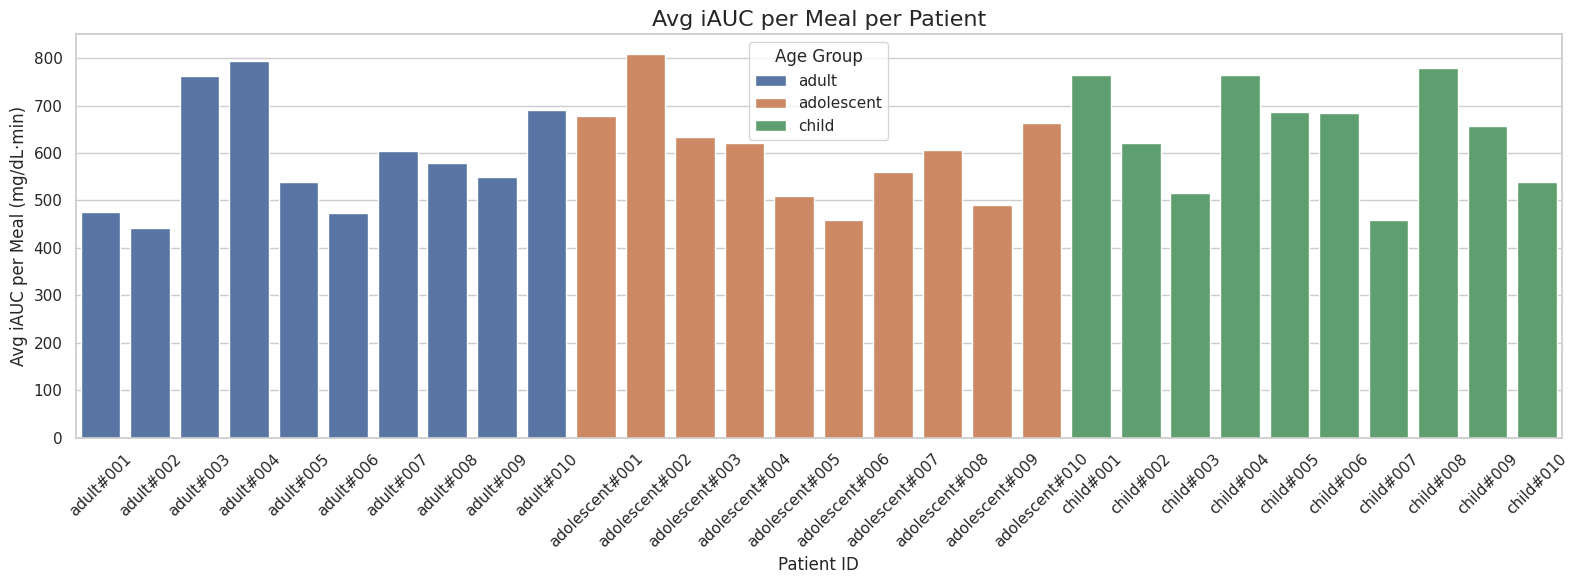

In [7]:
df_result['avg_iAUC_per_meal'] = df_result['iAUC'] / 27  # 9일 × 3식 = 27회 식사

import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# 막대 그래프 (환자당 1회 식단 기준 iAUC)
sns.barplot(data=df_result, x="patient", y="avg_iAUC_per_meal", hue="age_group", dodge=False)

# 시각화 옵션
plt.title("Avg iAUC per Meal per Patient", fontsize=16)
plt.xlabel("Patient ID", fontsize=12)
plt.ylabel("Avg iAUC per Meal (mg/dL·min)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()


In [12]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Processing meal plan 1/10...
⚠️ Warning: '- cheesy savory oatmeal (150g)' not found in dataset!
⚠️ Warning: '- grilled chicken salad (200g)' not found in dataset!
⚠️ Warning: '- orange-rosemary glazed salmon with broccolini (180g)' not found in dataset!
Mean iAUC for meal plan 1: 401.74
Processing meal plan 2/10...
⚠️ Warning: 'oatmeal (150g)' not found in dataset!
⚠️ Warning: 'lamb, kale, and pomegranate salad (200g)' not found in dataset!
⚠️ Warning: 'salmon fillet (180g)' not found in dataset!
Mean iAUC for meal plan 2: 385.69
Processing meal plan 3/10...
⚠️ Warning: 'cheesy savory oatmeal(150g)' not found in dataset!
⚠️ Warning: 'grilled chicken with plums and zucchini skewers(200g)' not found in dataset!
⚠️ Warning: 'salmon fillet(180g)' not found in dataset!
Mean iAUC for meal plan 3: 355.14
Processing meal plan 4/10...
⚠️ Warning: 'ginger infused oatmeal (150g)' not found in dataset!
⚠️ Warning: 'grilled chicken salad (200g)' not found in dataset!
⚠️ Warning: 'orange-rosemary gl

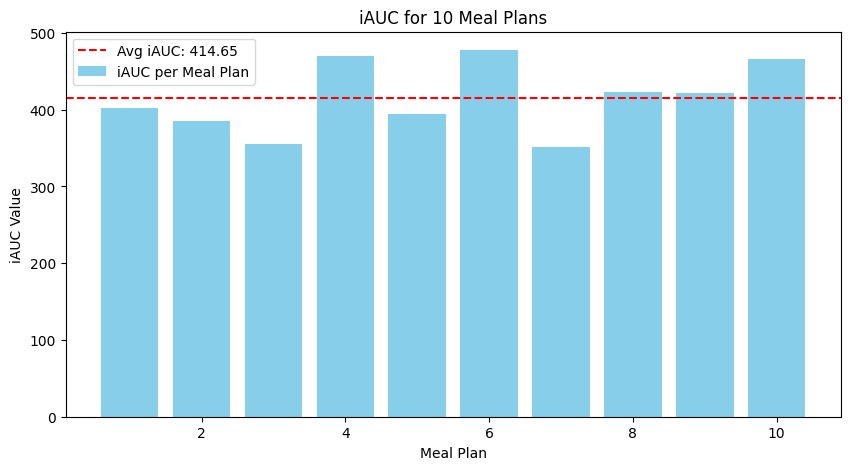

In [1]:
import gym
import simglucose.simulation.scenario as scenario
from simglucose.controller.base import Action
from simglucose.simulation.env import T1DSimEnv
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
from scipy.integrate import simpson  # iAUC 계산
from simglucose.simulation.scenario import CustomScenario

### 🔹 1️⃣ 탄수화물 데이터 로드
csv_path = "/data/jaesung/llm_for_diabetes/src/trial4/recommendation/diabetes_food_hub.csv"
df = pd.read_csv(csv_path)
df["title_lower"] = df["title"].str.lower()


def get_carbs(food_name):
    """주어진 음식의 탄수화물(g)을 데이터에서 찾아 반환"""
    food_name = food_name.lower().strip()
    match = df[df["title_lower"] == food_name]
    
    if not match.empty:
        try:
            return float(match["carbs"].values[0])  # 탄수화물 정보 반환
        except KeyError:
            pass
    print(f"⚠️ Warning: '{food_name}' not found in dataset!")
    return 0  # 데이터 없으면 0 반환

### 🔹 2️⃣ 환자 데이터 불러오기
patient_name = 'adult#001'
patient_params_file = pkg_resources.resource_filename('simglucose', 'params/vpatient_params.csv')
patient_params = pd.read_csv(patient_params_file)

# 🔹 해결: 환자 데이터 가져오면서 'Name' 컬럼 포함
patient_data = patient_params[patient_params['Name'] == patient_name].iloc[0]  # DataFrame → Series 변환

# 2️⃣ 환자 객체 생성 (params 전달 방식 수정)
patient = T1DPatient(params=patient_data)

### 🔹 3️⃣ CGM 센서 및 인슐린 펌프 설정
sensor = CGMSensor.withName("Dexcom")
pump = InsulinPump.withName("Insulet")

### 🔹 4️⃣ 시뮬레이션 함수 정의
def run_simulation(meal_plan):
    """meal_plan을 기반으로 혈당 변화를 시뮬레이션하고 iAUC 계산"""
    now = datetime.now()
    start_time = datetime.combine(now.date(), datetime.min.time())

    # 식단 기반 탄수화물 섭취량
    meal_times = [8, 12, 18]  # 아침, 점심, 저녁
    meal_carbs = [
        get_carbs(meal_plan.get("breakfast", "")),
        get_carbs(meal_plan.get("lunch", "")),
        get_carbs(meal_plan.get("dinner", ""))
    ]

    # 시뮬레이션 시나리오 (식사 시간 반영)
    scen = [(t, carbs) for t, carbs in zip(meal_times, meal_carbs)]
    scenario = CustomScenario(start_time=start_time, scenario=scen)

    # 시뮬레이션 환경 설정
    env = T1DSimEnv(patient, sensor, pump, scenario)

    # 시뮬레이션 실행
    obs = env.reset()
    results = []
    sim_time = datetime.now().replace(hour=6, minute=0, second=0)  # 6AM부터 시작

    for t in range(6):  # 48시간 동안 혈당 변화 예측
        carb_intake = meal_carbs[meal_times.index(sim_time.hour)] if sim_time.hour in meal_times else 0
        action = Action(basal=0, bolus=0)  # 인슐린 주입 없이 진행
        obs, _, _, _ = env.step(action)

        results.append({
            "time": sim_time.strftime("%H:%M"),
            "blood_glucose": obs.CGM,
            "carb_intake": carb_intake
        })

        sim_time += timedelta(minutes=30)  # 30분 간격으로 진행

    # DataFrame 변환
    df_results = pd.DataFrame(results)

    # iAUC 계산 (Simpson's Rule)
    glucose_values = df_results["blood_glucose"].values
    time_intervals = np.linspace(0, len(glucose_values) * 0.5, len(glucose_values))  # 30분 단위 시간

    iauc = simpson(glucose_values, time_intervals)  # Simpson's Rule 사용
    return iauc

### 🔹 5️⃣ 10번 반복 실행
iauc_results = []

meal_plans = [
    {'breakfast': '- Cheesy Savory Oatmeal (150g)', 'lunch': '- Grilled Chicken Salad (200g)', 'dinner': '- Orange-Rosemary Glazed Salmon with Broccolini (180g)'},
    {'breakfast': 'Oatmeal (150g)', 'lunch': 'Lamb, Kale, and Pomegranate Salad (200g)', 'dinner': 'Salmon Fillet (180g)'},
    {'breakfast': 'Cheesy Savory Oatmeal(150g)', 'lunch': 'Grilled Chicken with Plums and Zucchini Skewers(200g)', 'dinner': 'Salmon Fillet(180g)'},
    {'breakfast': 'Ginger Infused Oatmeal (150g)', 'lunch': 'Grilled Chicken Salad (200g)', 'dinner': 'Orange-Rosemary Glazed Salmon with Broccolini (180g)'},
    {'breakfast': 'Oatmeal(150g)', 'lunch': 'Grilled Chicken with Plums and Zucchini Skewers(200g)', 'dinner': 'Tilapia Stew with Green Peppers(180g)'},
    {'breakfast': 'Strawberry Banana "Ice Cream" (200g)', 'lunch': 'Chicken and Cucumber Lettuce Wraps with Peanut Sauce (250g)', 'dinner': 'Orange-Rosemary Glazed Salmon with Broccolini (180g)'},
    {'breakfast': 'Chickpea Pasta & Seasoned Ricotta with Caramelized Fennel and Onion (300g)', 'lunch': 'Chicken Apple Crunch Salad (250g)', 'dinner': 'Broccoli and Apple Salad (200g)'},
    {'breakfast': 'Cheesy Savory Oatmeal(150g)', 'lunch': 'Colorful Pasta Salad(200g)', 'dinner': 'Parmesan Tofu with Butternut Squash Noodles(180g)'},
    {'breakfast': 'Ginger Infused Oatmeal (150g)', 'lunch': 'Chicken Apple Crunch Salad (200g)', 'dinner': 'Parmesan Tofu with Butternut Squash Noodles (180g)'},
    {'breakfast': 'Ginger Infused Oatmeal (150g)', 'lunch': 'Winter Salad With Champagne Vinaigrette and Pomegranate (200g)', 'dinner': 'Succulent Salmon With Caramelized Onions (180g)'}
]

# meal_plans = [{'breakfast': 'Not found', 'lunch': 'Not found', 'dinner': 'Not found'},
#  {'breakfast': 'Jamaican Pork Tenderloin Roast(150g)',
#   'lunch': 'Lamb, Kale, and Pomegranate Salad(200g)',
#   'dinner': 'Spiced Ginger Carrot Soup(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Grilled Chicken Salad(200g)',
#   'dinner': 'Salmon Fillet(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Grilled Chicken Salad(200g)',
#   'dinner': 'Salmon Fillet(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Grilled Chicken Salad(200g)',
#   'dinner': 'Salmon Fillet(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Grilled Chicken Salad(200g)',
#   'dinner': 'Salmon Fillet(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Grilled Chicken Salad(200g)',
#   'dinner': 'Salmon Fillet(180g)'},
#  {'breakfast': 'Oatmeal(150g)',
#   'lunch': 'Pasta Fagioli(200g)',
#   'dinner': 'Parmesan Tofu with Butternut Squash Noodles(180g)'},
#  {'breakfast': 'Not found', 'lunch': 'Not found', 'dinner': 'Not found'},
#  {'breakfast': 'OK Oatmeal with Strawberries and Almonds(150g)',
#   'lunch': 'Ensalada de zanahoria y col(200g)',
#   'dinner': 'Succulent Salmon With Caramelized Onions(180g)'}]

for idx, meal_plan in enumerate(meal_plans):
    print(f"Processing meal plan {idx+1}/10...")
    mean_iauc = run_simulation(meal_plan)
    iauc_results.append(mean_iauc)
    print(f"Mean iAUC for meal plan {idx+1}: {mean_iauc:.2f}")

# 평균 iAUC 출력
average_iauc = np.mean(iauc_results)
print(f"\n✅ Average iAUC over 10 meal plans: {average_iauc:.2f}")

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), iauc_results, color="skyblue", label="iAUC per Meal Plan")
plt.axhline(average_iauc, color="red", linestyle="--", label=f"Avg iAUC: {average_iauc:.2f}")
plt.xlabel("Meal Plan")
plt.ylabel("iAUC Value")
plt.title("iAUC for 10 Meal Plans")
plt.legend()
plt.show()
